## ***Fluvial Sedimentary Response on Large Deep-Seated landslide Events***
### CSDMS ESPIn 2024: Event-Sediment-Pluse Team
Contributers (listed in the aphabetic order of last name): 
- Nilay Iscen
- John Kemper
- Larry Syu-Heng Lai
- Yuan Li

___

## Introduction

Large deep-seated landslides area important events to alter the hillslopes and relocate large amount of the sedimentary mass to the river network. However, how fast could this landslide-derived sedimentary signal propagate through the river network remain poorly known and difficult to be tracked in a real world system. In this team project, we adapt several landscape evolution modules from the `landlab` v2.7 to simulate how a landslide-prone fluvial landscape respond to a sudden sediment supply by short-term catastrophic landslide event.

<img src="ososlide.jpg" alt="drawing" width="600"/>

*2014 Oso Landlside, WA (image from The Seattle Times)*
<hr>

In this notebook, we will utilize the **GravelBedrockEroder**, **BedrockLandslider**, **FlowAccumulator** and **DepressionFinderAndRouter** components to perform the analysis through following steps:

* Step 1: Setup an steady-state initial landscape before catastropic landslide event
    * Run simulation using SPACE
    * Show the landform, sediment thickness, and river long-profile

* Step 2: Hit a 20-year-long catastrophic landslide "event" to the landscape
    * Run simulation using Hyland (BedrockLandsider) for 20 years
    * Show the landform, sediment thickness, and river long-profile

* Step 3: See how landslide-derived sediments affect the evolution of downstream channels.
    * Run simulation using GravelBedrockEroder for 20 years
    * Plot changing landform/profile, soil thickness of each time step (every year)

We also have an EXTRA Step, in which we import modeling outcome from the landslide-evet team in our step 3. Instead of using a synthetic landscape, the landslide-evet team imposes landslide events on a real landscape using two model's, the **BedrockLandslider** and a mass-wasting module, to compare the results and show how our analysis may be applied to real-world research. 

<hr>

References:
* Shobe, C. M., Tucker, G. E., and Barnhart, K. R.: The SPACE 1.0 model: a Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution, Geosci. Model Dev., 10, 4577-4604, https://doi.org/10.5194/gmd-10-4577-2017, 2017. 
* Campforts, B., Shobe, C. M., Steer, P., Vanmaercke, M., Lague, D., and Braun, J.: HyLands 1.0: a hybrid landscape evolution model to simulate the impact of landslides and landslide-derived sediment on landscape evolution, Geosci. Model Dev., 13, 3863–3886, https://doi.org/10.5194/gmd-13-3863-2020, 2020.
* GravelBedrockEroder: rock incision, bed-load transport, and downstream abrasion in a river network. https://landlab.readthedocs.io/en/latest/reference/components/gravel_bedrock_eroder.html


<hr>

### Importing necessary libraries and components:

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt  # For plotting results; optional
import numpy as np

from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid, imshowhs_grid  # For plotting results; optional
from landlab.components import BedrockLandslider  # BedrockLandslider model
from landlab.components import SpaceLargeScaleEroder  # SPACE model
from landlab.components import PriorityFloodFlowRouter
from landlab.components import FlowAccumulator, GravelBedrockEroder # GBE model
from landlab.components import ChannelProfiler # channel profiles with sediment

import pickle # For saving and loading landlab grid object 

#### Define plotting function for long-river profile of the main trunk

In [2]:
def plot_profile_soil(mg):

    profiler = ChannelProfiler(mg)
    profiler.run_one_step()
    riv_nodes = profiler.nodes

    mg.at_node["bedrock_elevation"]=mg.at_node["topographic__elevation"]-mg.at_node["soil__depth"]
    dist_atNodes=profiler.distance_along_profile[0]

    el = mg.at_node["topographic__elevation"][riv_nodes]
    sd = mg.at_node["soil__depth"][riv_nodes]

    br = el-sd     # Use ravel() to flatten el and br to 1D
    el = el.ravel()
    sd = sd.ravel()
    br = br.ravel() # Calculate minimum elevation and relief

    min_elevation = min(np.min(el), np.min(br), 0)
    el_relief = el - min_elevation
    br_relief = br - min_elevation

    qs = mg.at_node["sediment__flux"][riv_nodes]
    qs[np.where(qs<10)] = np.nanplt_fontsize =10     

    fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
    ax2 = ax1.twinx()

    dist = (max(dist_atNodes)-dist_atNodes)*1e-3
    brown_c = [205/255,133/255,63/255] # Fill the entire area from max relief to 0

    ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area') # Fill the bedrock and colluvial material relief
    ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
    ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material') # Plot bedrock and topographic relief

    lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
    lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4) # set up labels

    ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=10.0)
    ax1.tick_params(labelsize=10.0)
    ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=10.0)
    ax1.set_ylim((np.min(el_relief), np.max(el_relief)*1.1))


    # plot sediment thickness
    lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)

    ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=10.0)
    ax2.set_ylim((0, np.nanmax(sd)*1.4))
    #ax2.set_xlim((0, dist[2]))
    ax2.tick_params(labelsize=10.0) # Merge legends

    lns = lns1 + lns2 + lns3
    labs = [l.get_label() for l in lns]

    ax1.legend(lns, labs, fontsize=10.0) # Set y-axis to start from 0
    ax1.set_ylim(bottom=0)

#### Define plotting function for mapview figures

In [3]:
"""
Created on Sun Aug 4 
@author: YLiHD

Plot topography, channel network over topography and soil depth

### To do: write comments (input, output, ...)

"""
import copy
import matplotlib.pyplot as plt  # For plotting results; optional
import matplotlib as mpl
from landlab import imshow_grid, imshowhs_grid  # For plotting results; optional

def plt_landscape_evo(profiler, mg):

    # Set the size of the canvas
    plt.figure(figsize=(13,4))
    
    # Show topography with channel network
    cmap_terrain = copy.copy(mpl.colormaps["terrain"])
    plt.subplot(1,2,1)
    profiler.plot_profiles_in_map_view(cmap = cmap_terrain)
    
    # Show Soil thickness
    cmap_pink = copy.copy(mpl.colormaps["pink"])
    plt.subplot(1,2,2)
    imshow_grid(
        mg,
        mg.at_node["soil__depth"],
        colorbar_label="Soil depth (m) ",
        cmap=cmap_pink,
    )
    
    # Plot figure
    plt.show()

<hr>

### STEP 1: **Creating a synthetic initial steady-state landscape:**
Here, we use **SPACE**, **PriorityFloodFlowRouter** to setup a synthetic initial landscape before impacted by the large landslide event

### Instantiating the model grid:

* instantiate the model grid, and set the boundary conditions
* All boundary edges are set to be closed. Only 
The bottom left corner is the watershed outlet, which is set as an open boundary condition to allow flux out. 
All other boundary nodes are closed. 

Creating fields.

More here..

In [4]:
# Create initial model topography:

# Set model grid shape and size
num_rows = 30
num_columns = 30
node_spacing = 25.0

# Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing) 
mg.add_zeros("node", "topographic__elevation") # add field ’topographic elevation’ to the grid
# add topographic roughness
random_noise = (np.random.rand(len(mg.node_y)) / 1000.0)  # impose topography values on model grid
mg["node"]["topographic__elevation"] += random_noise

mg.add_zeros("node", "soil__depth") # Create a field 'soil__depth' to the grid
mg.at_node["soil__depth"][mg.core_nodes] = 1.0  #Set s m of initial soil depth at core nodes

# Add field 'bedrock__elevation' to the grid
mg.add_zeros("bedrock__elevation", at="node")

# Yield 'topographic elevation' by summing 'soil__depth' and 'bedrock__elevation'
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

# Close all model boundary edges except the node #5, allowing only one outlet
mg.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True,
    left_is_closed=True,
    right_is_closed=True,
    top_is_closed=True,
)
mg.status_at_node[0] = 1 

### Instantiating model components for the initial landscape:

Here we instantiate the **PriorityFloodFlowRouter** and **BedrockLandslider**..

In [5]:
# Instantiate flow router
fr = PriorityFloodFlowRouter(mg, flow_metric="D8", suppress_out=True)

# Instantiate SPACE model with chosen parameters
sp = SpaceLargeScaleEroder(
    mg,
    K_sed=2.5e-5,
    K_br=2.5e-5,
    F_f=0.0,
    phi=0.0,
    H_star=1.0,
    v_s=1,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

### Run SPACE to generate the initial semi-steady-state landscape
We use/iterate the **SPACE** through a time loop to evolve the landscape to a steady state before adding landslide component.

In [6]:
# Set model parameters
timestep = 500       # timestep in years
elapsed_time = 0.0   # Set elapsed time to zero
count = 0            # Set timestep count to zero
run_time = 500000    # Set model run time
U = 0.001            # Uplift rate in m/yr
sed_flux = np.zeros(int(run_time // timestep)) # Array to save sediment flux values

cmap = copy.copy(mpl.colormaps["terrain"])  # Define the color map for elevation

while elapsed_time < run_time:  # time units of years
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
        mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Add to value of elapsed time
    elapsed_time += timestep

    if np.mod(elapsed_time, 1e5) == 0:
        print("%.2f of model run completed" % (elapsed_time / run_time))

0.20 of model run completed
0.40 of model run completed
0.60 of model run completed
0.80 of model run completed
1.00 of model run completed


##### Export pre-landslide initial landscape landlab grid object as a pickle file

In [7]:
# Exporting landlab grid object
with open('pre-slide_fakelandscape.pickle', 'wb') as f:
    pickle.dump(mg, f)

### Plotting drainage network, river profile, and other attributes

##### Plot landscape, soildepth, and plane-view river network

In [8]:
# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()

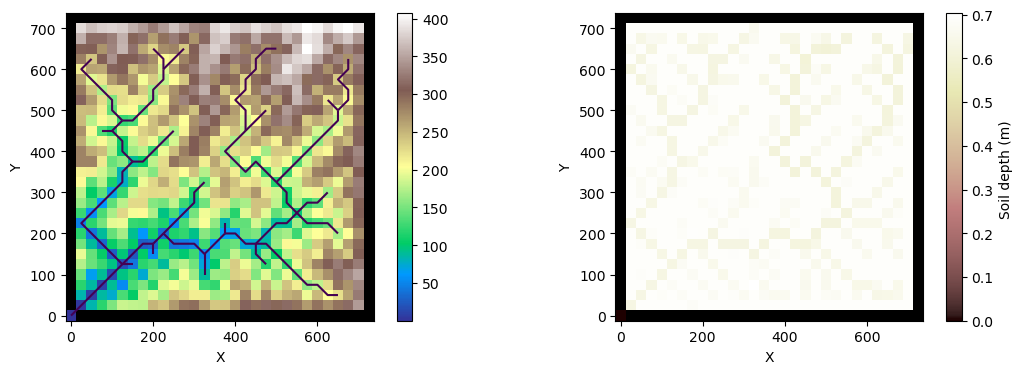

In [9]:
plt_landscape_evo(profiler,mg)

#### Plot long-river profile and other info (Nilay)
##### ***Inspired by Dr. Susannah Morey's unpublished works***

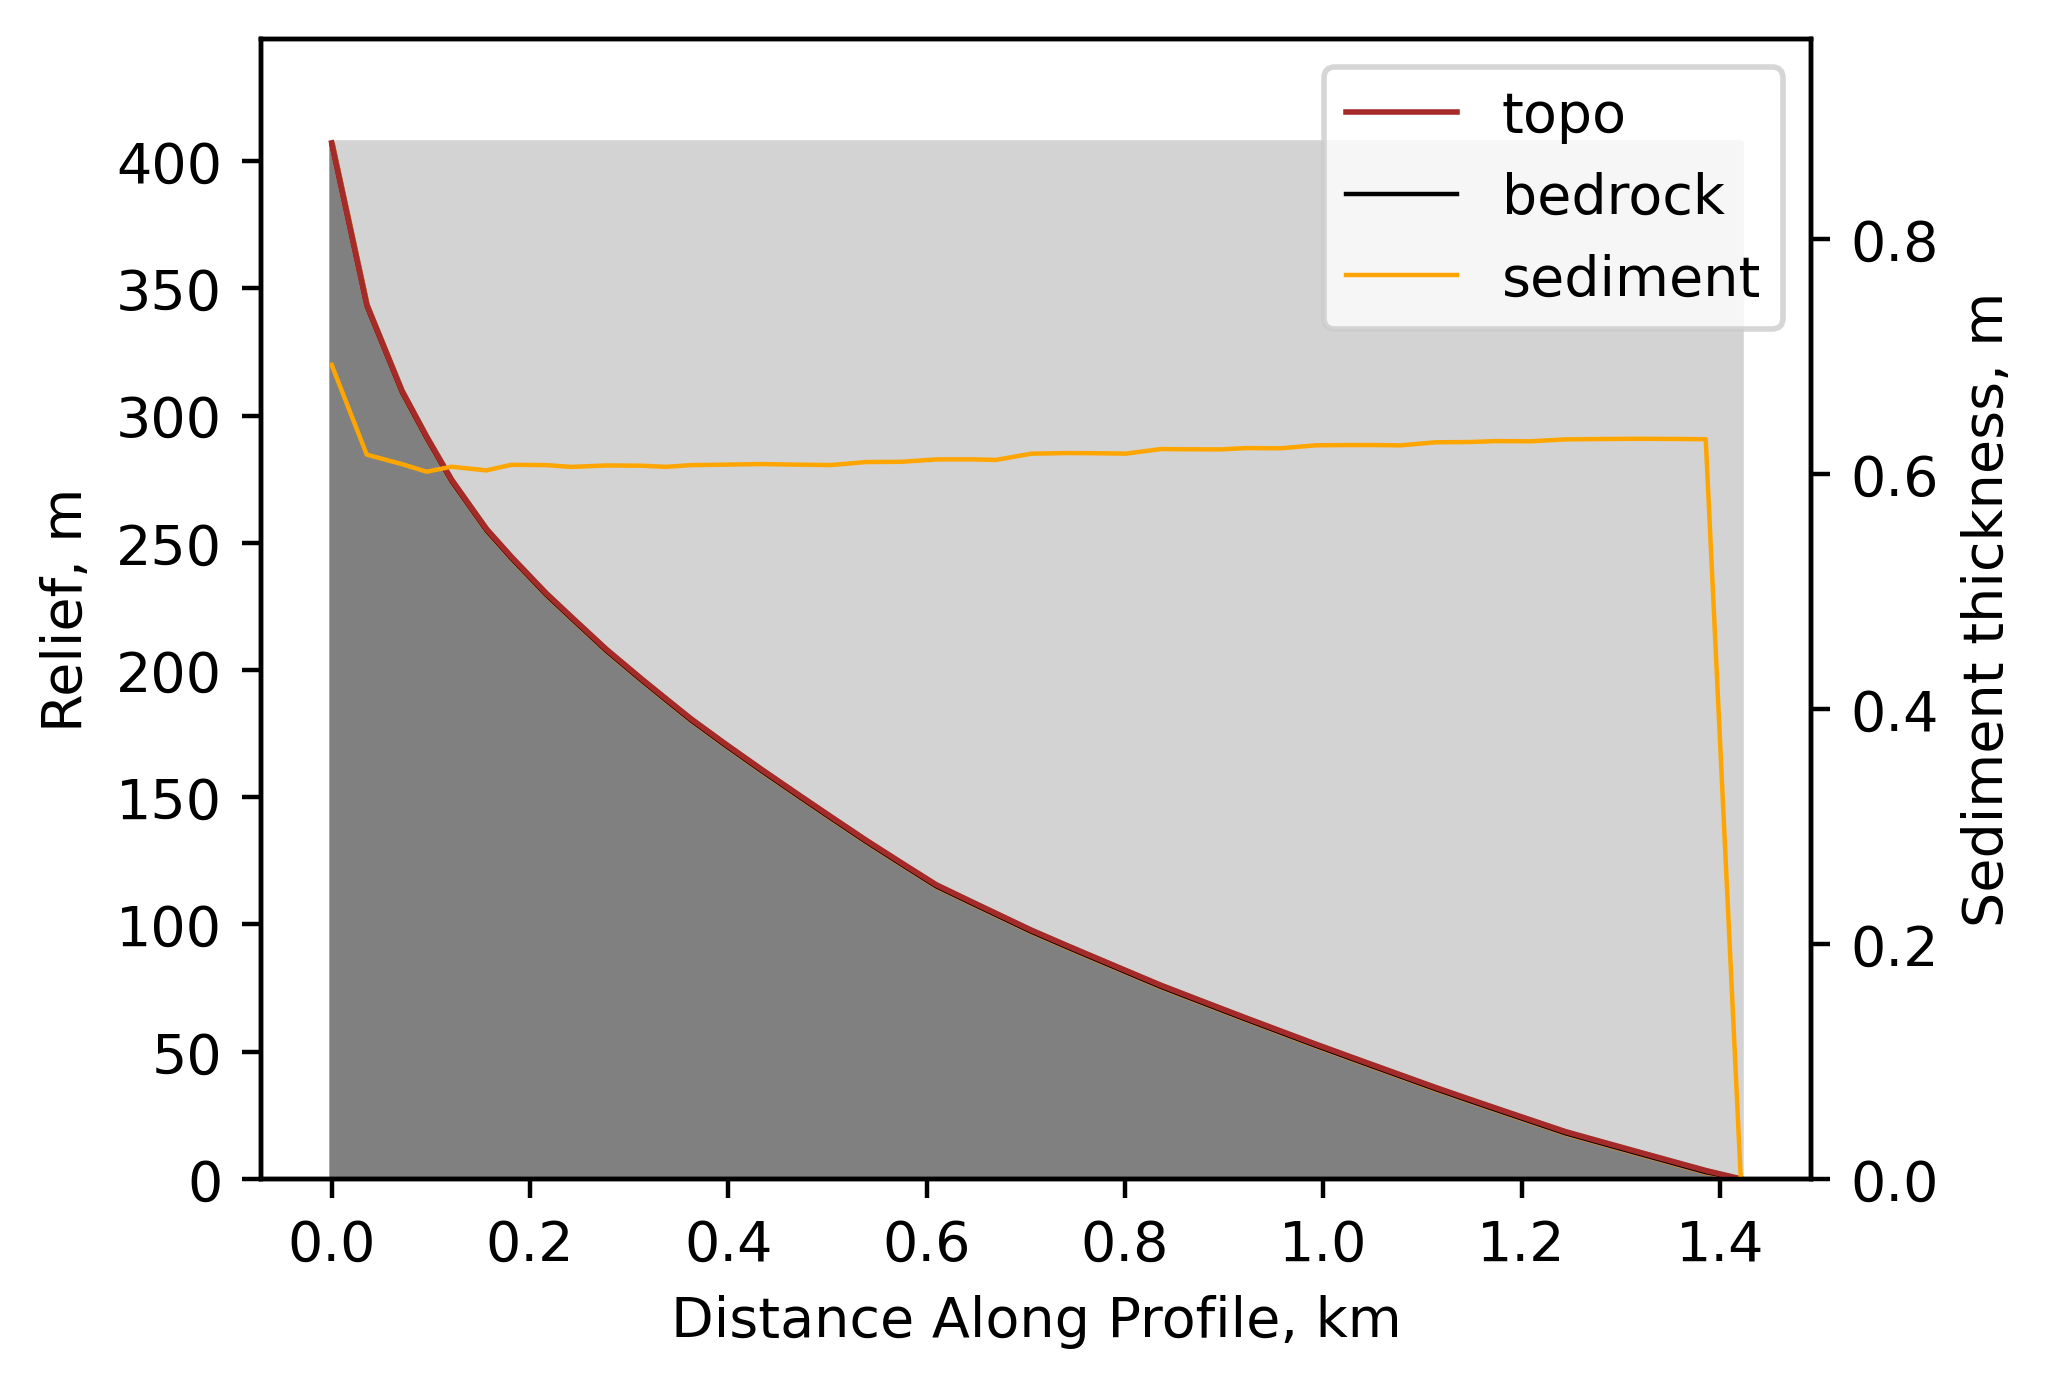

In [10]:
plot_profile_soil(mg)

<hr>

## STEP 2: **Hit the catastrophic landslide event to the landscape:**
### Run the Hyland (Bedrocklandslider) to the steady-state landscape for 20 years:

Initialize the flow director and SPACE and BedrockLandslider components

In [11]:
# Instantiate flow router, with additional multiple flow director for hillslopes
fr = PriorityFloodFlowRouter(
    mg,
    flow_metric="D8",
    separate_hill_flow=True,
    hill_flow_metric="Quinn",
    update_hill_flow_instantaneous=True,
)

# Instantiate SPACE model with chosen parameters
hy = BedrockLandslider(
    mg,
    angle_int_frict=0.4,
    cohesion_eff=1e3,
    landslides_return_time=1000,
    landslides_on_boundary_nodes=False,
)

Run the time loop over 20 years to develop a landscape with landslide activities

In [12]:
timestep = 2  # years
landslides_size_all_steps = []

for i in range(10):
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
        mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Run BedrockLandslider for one time step
    hy.run_one_step(dt=timestep)

    # Store landslide sizes of current time step into general ls_size list
    landslides_size_all_steps = np.append(landslides_size_all_steps, hy.landslides_size)

Export post-landslide landscape landlab grid object as a pickle file

In [13]:
# Exporting landlab grid object
with open('post-slide_fakelandscape.pickle', 'wb') as f:
    pickle.dump(mg, f)

##### Plot post-landslide landscape, soildepth, and plane-view river network etc (Yuan Li)

In [14]:
# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()

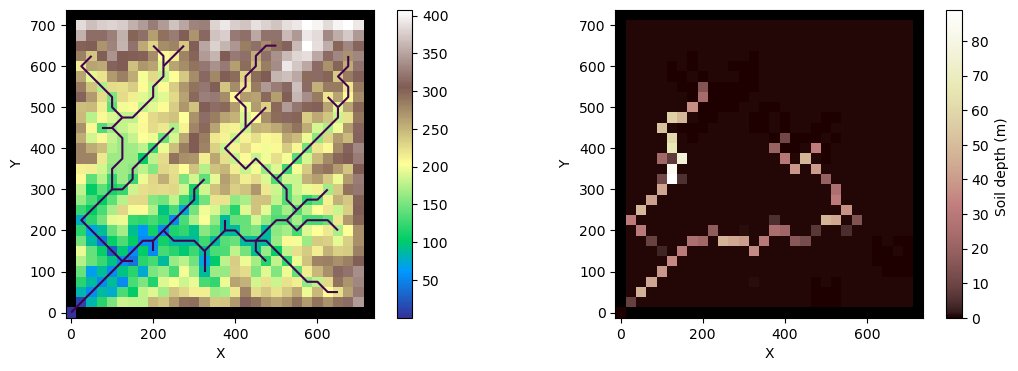

In [15]:
plt_landscape_evo(profiler,mg)

##### Plot river profile and other info for post-landslide landscape (Nilay)

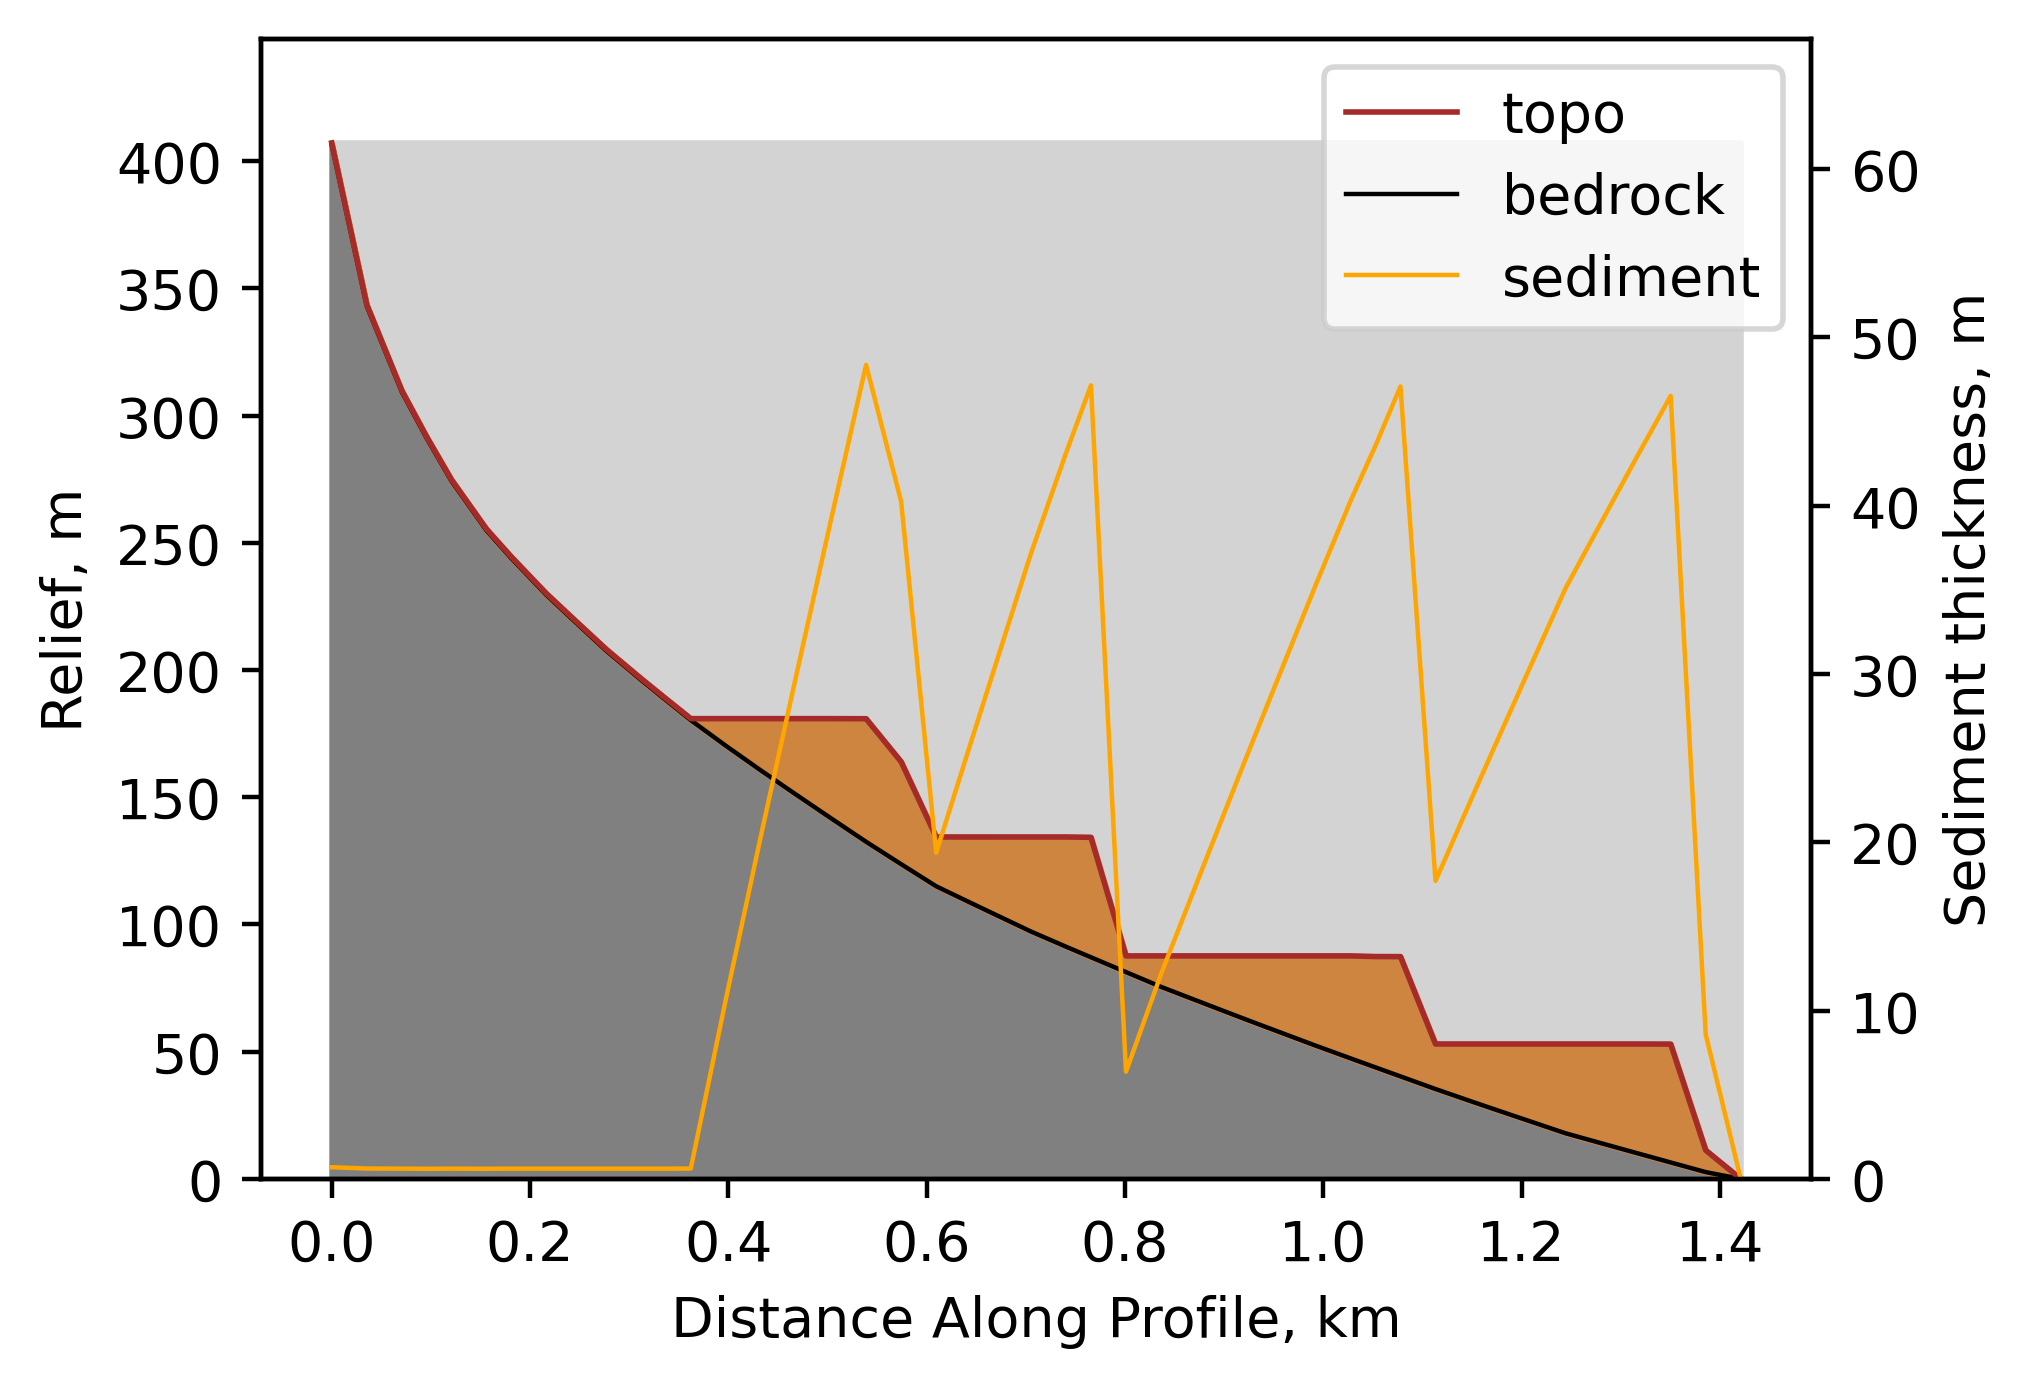

In [16]:
plot_profile_soil(mg)

You may think 10-60 meters of landslide deposit is unrealistic, but here is a great example showing > ~80 m landslide deposit happened at southwestern Taiwan in 2009:

<img src="shiaolinTWslide.jpg" alt="drawing" width="600"/>

*2009 Shaolin Landlside, Taiwan (image from AGU: https://blogs.agu.org/landslideblog/2010/02/02/the-causes-of-the-shiaolin-landslide-disaster-in-taiwan/)*

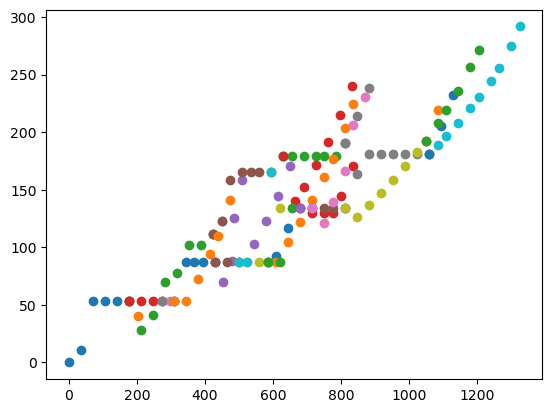

In [17]:
# channel profiles with sediment   ------- NiLAY added this, longer code ---------
dx = node_spacing
area_threshold = dx*dx*10.

profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()

#plot channel profiles

outlets = list(profiler.data_structure.keys()) #outlets from channel profiler
for outlet in outlets: #cycle thru outlets
    segments = list(profiler.data_structure[outlet].keys()) #segments for that watershed
    #print(segments)
    for i, segment in enumerate(segments): #cycle thru segments
        ids = profiler.data_structure[outlet][segment]['ids'] #ids (index) of each segment
        distance = profiler.data_structure[outlet][segment]['distances']#distance downstream of each segment node
        eta = mg.at_node['topographic__elevation'][ids] #elevation of each segment node
        plt.scatter(distance,eta,alpha=1) #plot profile
        #plt.plot(distance,eta,color='green',alpha=1)   
plt.show()

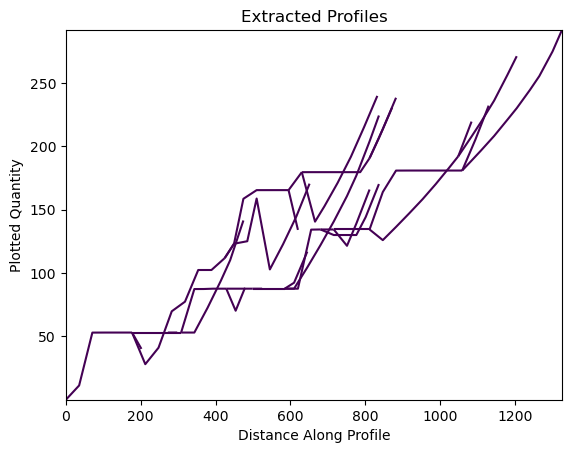

In [18]:
# VERY EASY WAY from methods/functions of the component:
profiler.plot_profiles()

<hr>

### STEP 3: See how landslide-derived sediments affect the evolution of downstream channels.
We run `GravelBedrockEroder` to simulate the fluvial response to landslide-driven sediment pulse through a short period of time (20 years in this case)

### Run GravelBedrockEroder (Need John's contribution)
Setup timestep, backgroup uplift rate, and flow routing. etc. and RUN

In [19]:
elev = mg.at_node["topographic__elevation"]

# fa = FlowAccumulator(mg, runoff_rate=10.0)
# fa.run_one_step()
eroder = GravelBedrockEroder(mg, abrasion_coefficient=0.0005,
                            coarse_fraction_from_plucking=0.1)
rock_elev = mg.at_node["bedrock__elevation"]
elev = mg.at_node["topographic__elevation"]
#years_forward = mg.add_zeros["years_in_future", at = "node"]
for i in range(20):
     rock_elev[mg.core_nodes] += 0.002  #rock uplift
     elev[mg.core_nodes] += 0.002       #rock uplift
     fr.run_one_step()
     mg.at_node["surface_water__discharge"] *= 1.0 / (3600 * 24 * 365.25)
     chan_width = eroder.calc_implied_width(time_unit="s")
     eroder.calc_sediment_rate_of_change(),
     eroder.run_one_step(1.0)

##### Plot post-Gravel Bedrock erosion landscape, soildepth, and plane-view river network etc (Yuan Li)

In [20]:
# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()

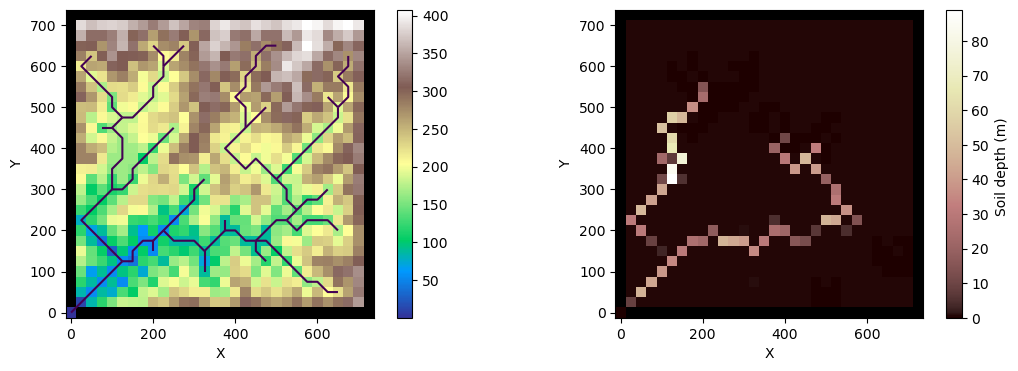

In [21]:
plt_landscape_evo(profiler,mg)

##### Plot river profile and other info for post-landslide landscape (Nilay)

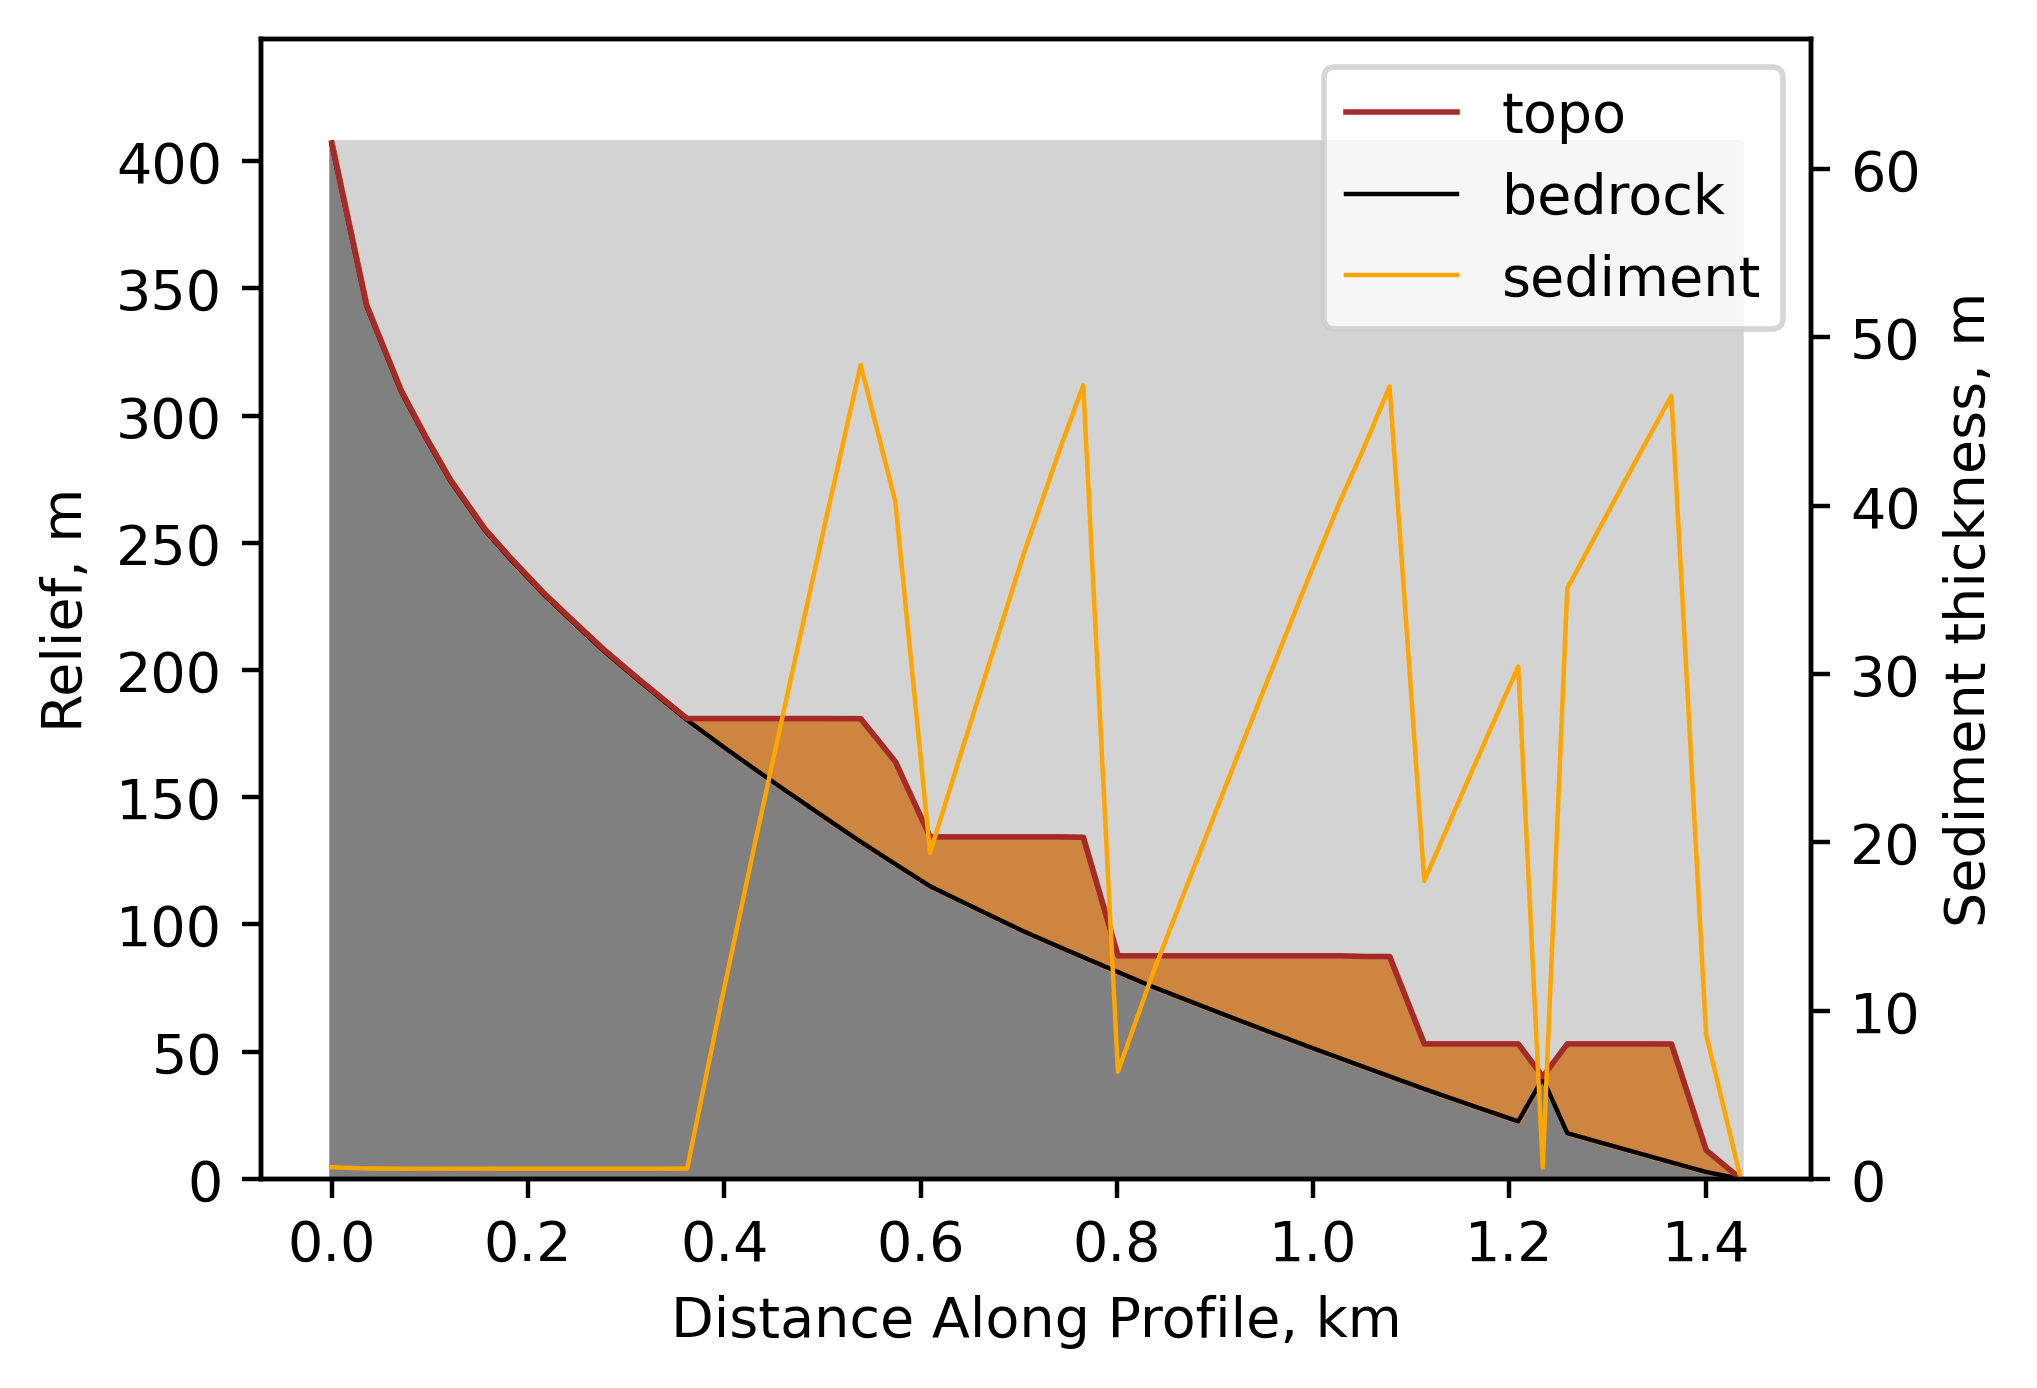

In [22]:
plot_profile_soil(mg)

<hr>

### EXTRA STEP: load and analyze real landscape

In [23]:
# import pickle file of real pre-landslide landlab grid object
with open('pre-slide_landscape.pickle', 'rb') as g:
    mg2 = pickle.load(g)

# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler2 = ChannelProfiler(mg2, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler2.run_one_step()

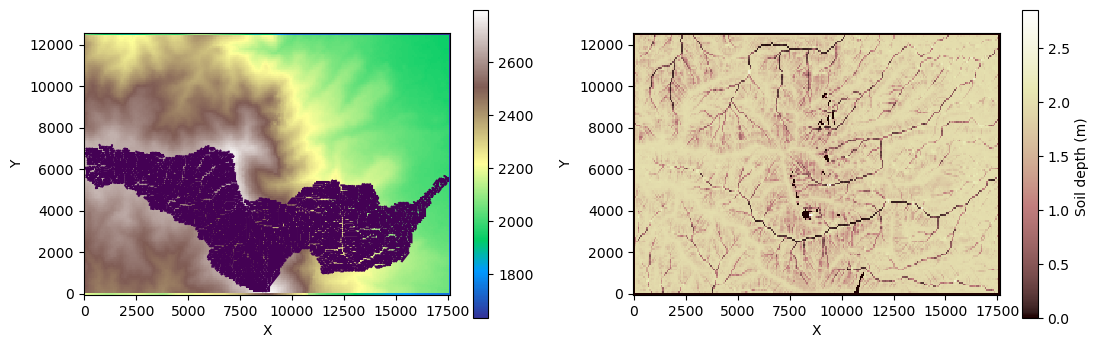

In [24]:
plt_landscape_evo(profiler2, mg2)

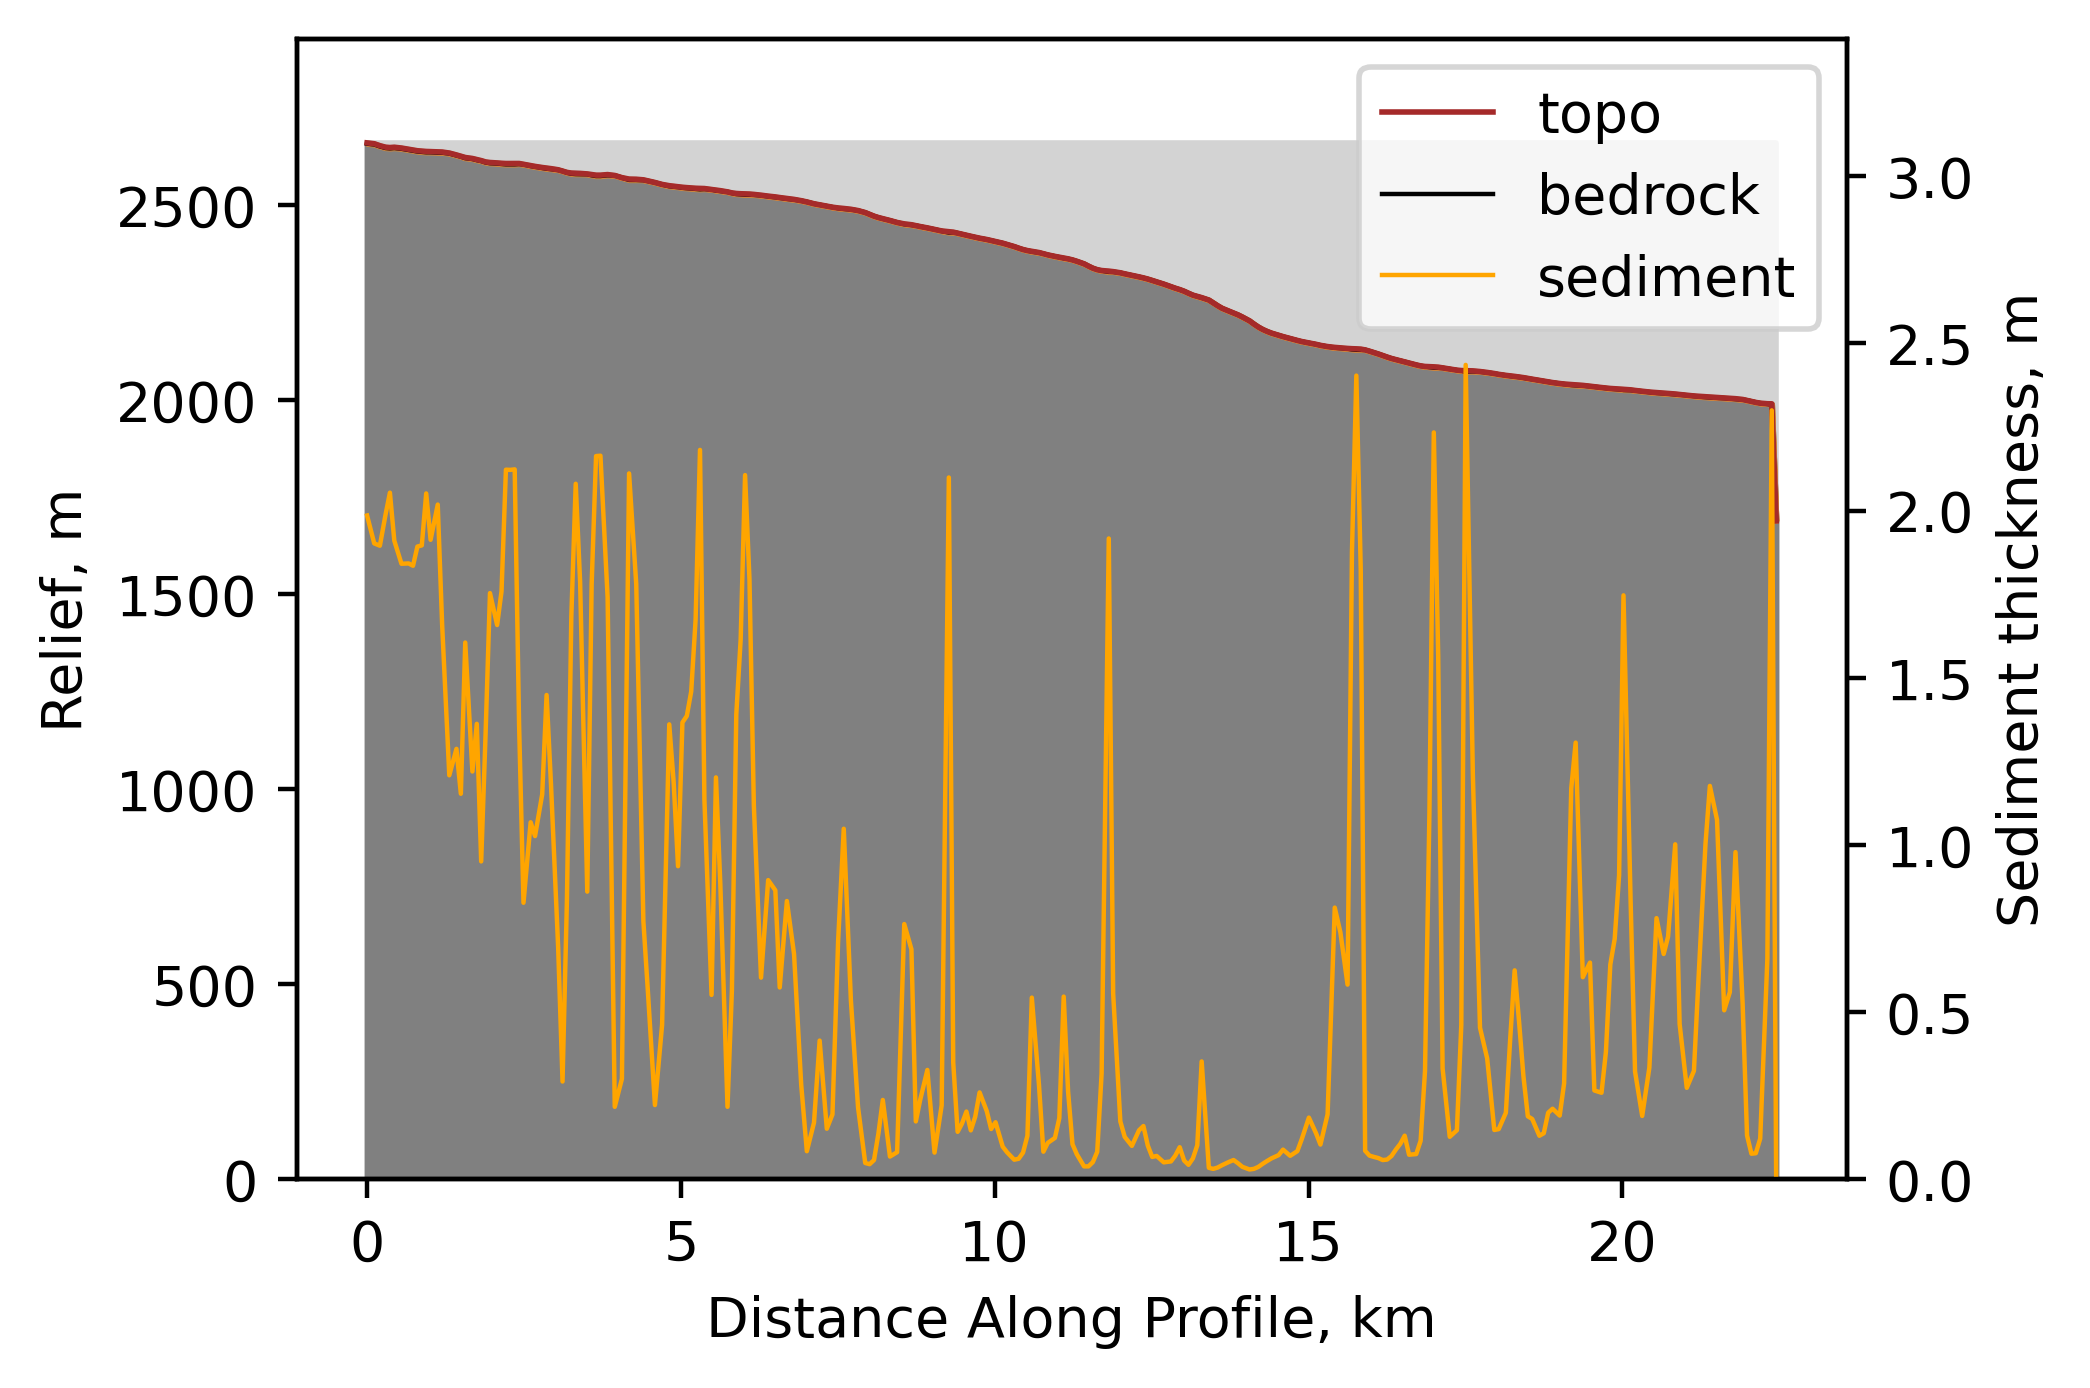

In [25]:
plot_profile_soil(mg2)

In [26]:
# Import pickle file of real post-landslide landlab grid object
with open('post-bedrock-slide_landscape.pickle', 'rb') as g:
    mg3 = pickle.load(g)

# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler3 = ChannelProfiler(mg3, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler3.run_one_step()

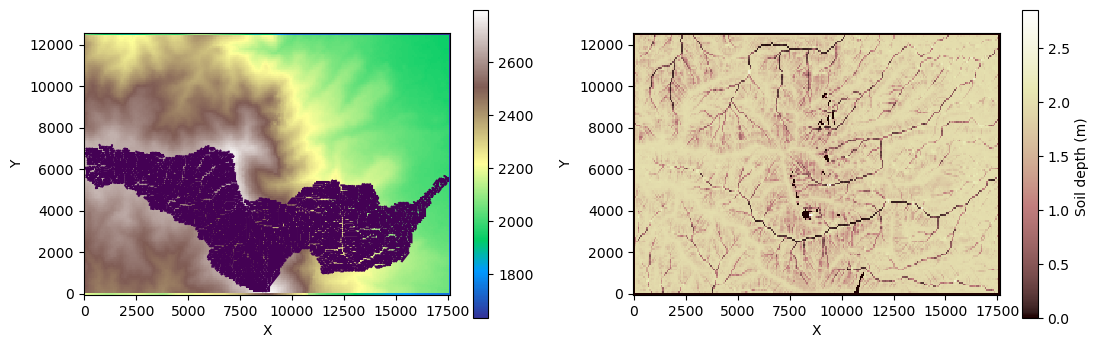

In [27]:
plt_landscape_evo(profiler3, mg3)

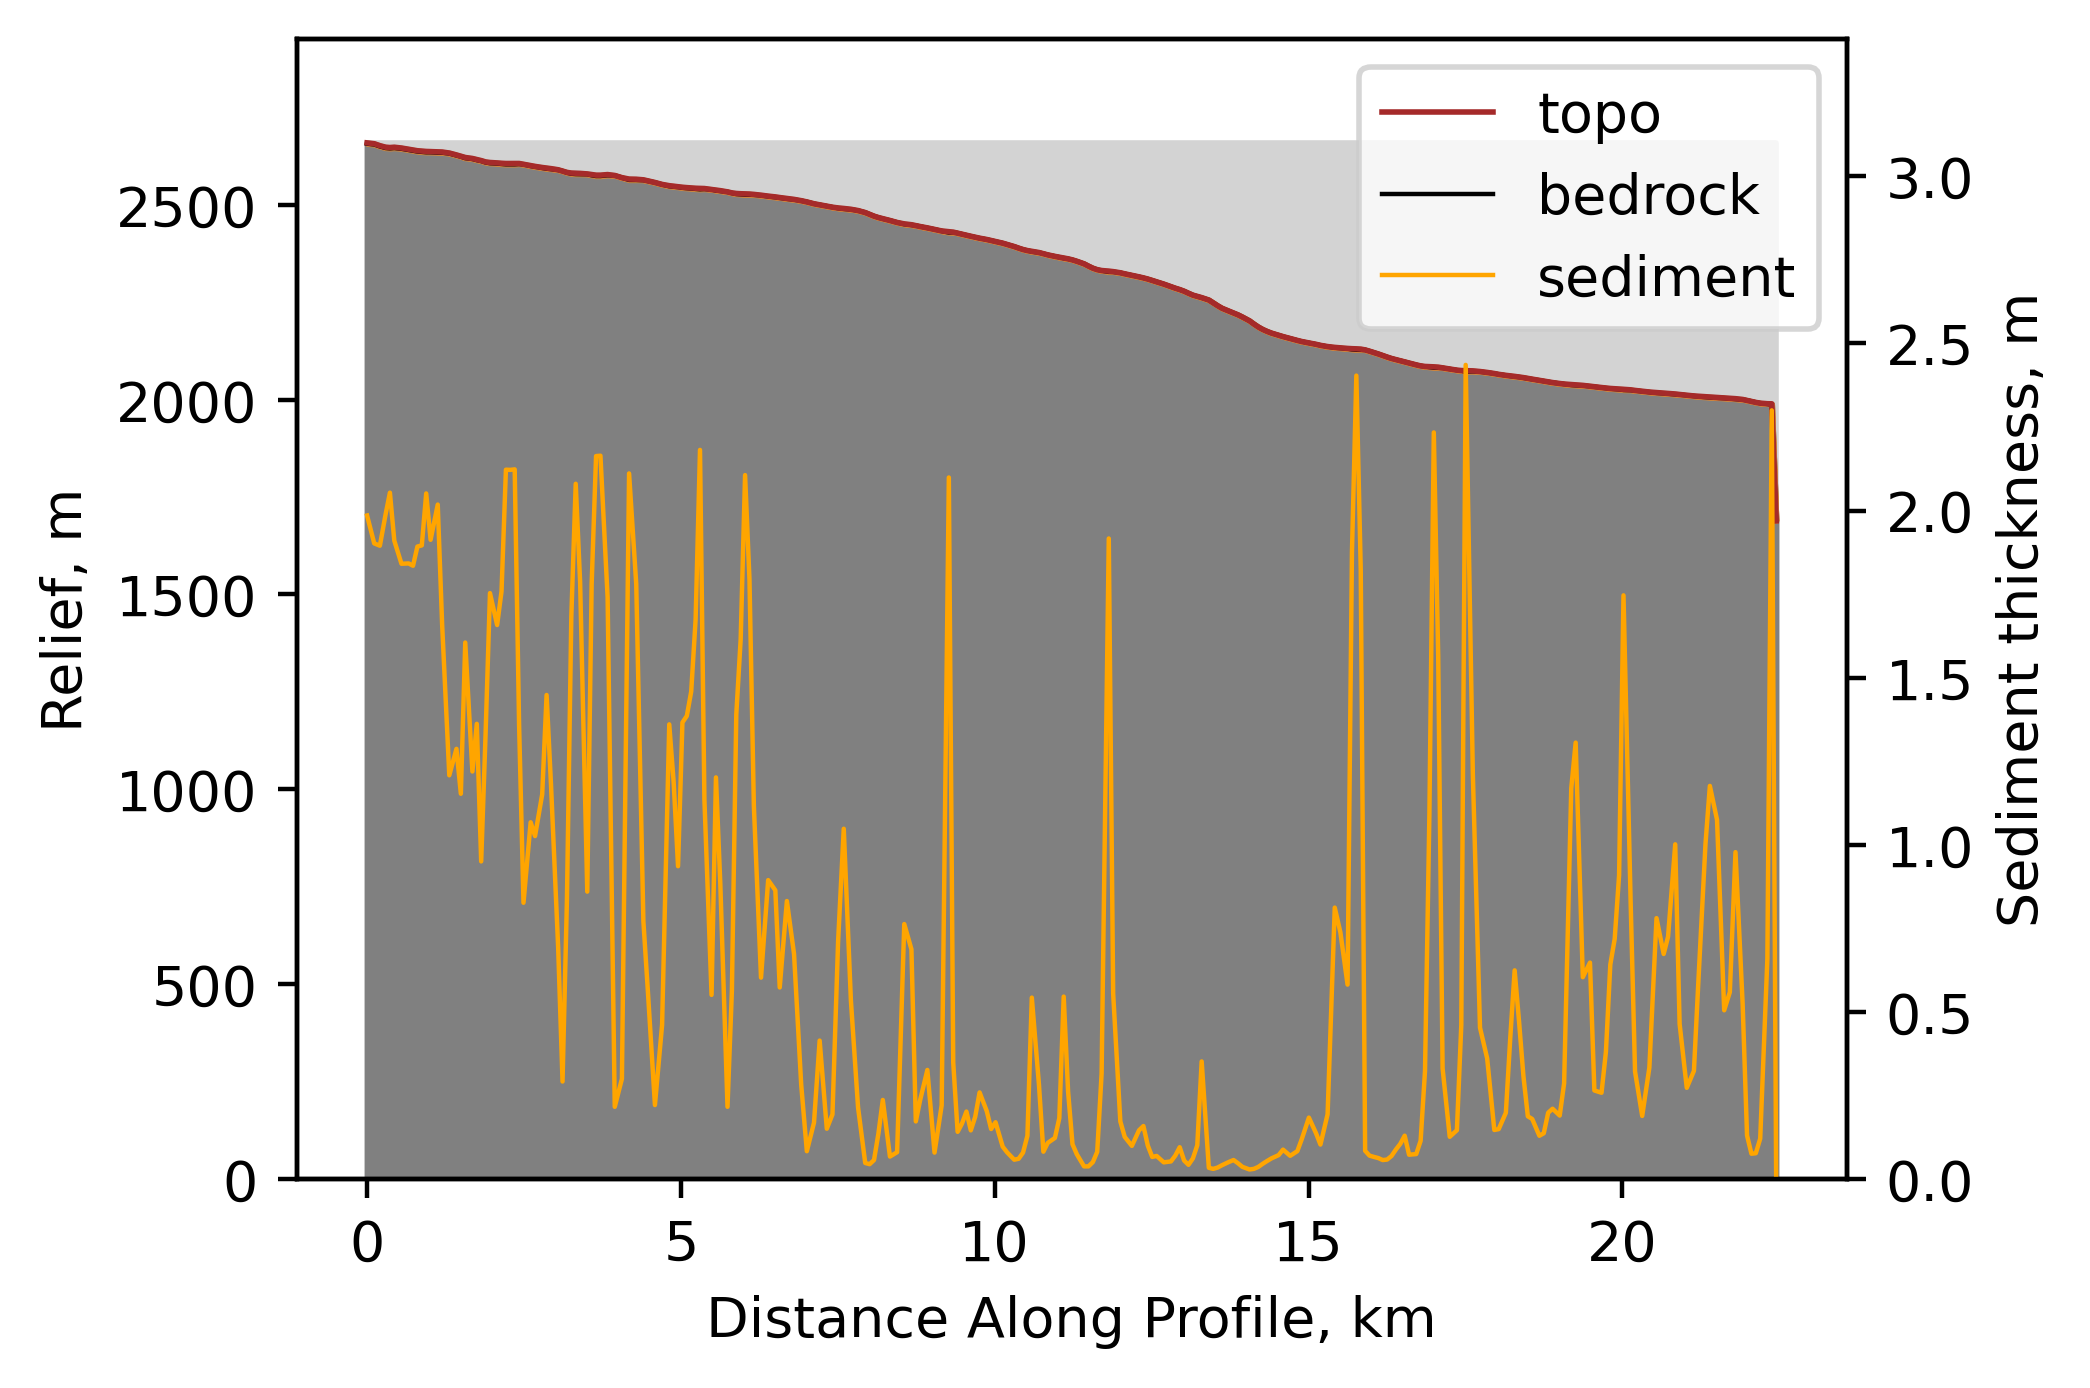

In [28]:
plot_profile_soil(mg3)

#### Run GravelBedrockEroder on imported post-landslide landscape DEM

In [29]:
elev = mg2.at_node["topographic__elevation"]

# fa = FlowAccumulator(mg2, runoff_rate=10.0)
# fa.run_one_step()
eroder = GravelBedrockEroder(mg2, abrasion_coefficient=0.0005,
                            coarse_fraction_from_plucking=0.1)
rock_elev = mg2.at_node["bedrock__elevation"]
elev = mg2.at_node["topographic__elevation"]
#years_forward = mg.add_zeros["years_in_future", at = "node"]

for i in range(200):
     rock_elev[mg2.core_nodes] += 0.002
     elev[mg2.core_nodes] += 0.002
     fr.run_one_step()
     mg2.at_node["surface_water__discharge"] *= 1.0 / (3600 * 24 * 365.25)
     chan_width = eroder.calc_implied_width(time_unit="s")
     eroder.calc_sediment_rate_of_change(),
     eroder.run_one_step(1.0)

/Users/larryslai/Documents/GitHub/landlab/landlab/components/gravel_bedrock_eroder/gravel_bedrock_eroder.py:728: RuntimeWarning: overflow encountered in divide
  -self._sed[sed_is_declining] / self._dHdt[sed_is_declining]
/Users/larryslai/Documents/GitHub/landlab/landlab/components/gravel_bedrock_eroder/gravel_bedrock_eroder.py:738: RuntimeWarning: overflow encountered in divide
  height_above_rcvr[slope_is_declining] / rate_diff[slope_is_declining]


In [30]:
# Derive river network using ChannelProfiler
dx = node_spacing
area_threshold = dx*dx*10.
profiler3 = ChannelProfiler(mg3, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler3.run_one_step()

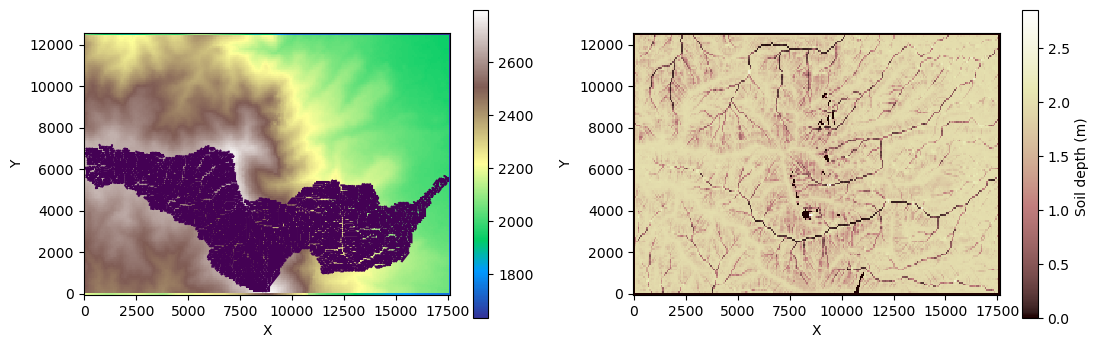

In [31]:
plt_landscape_evo(profiler3, mg3)

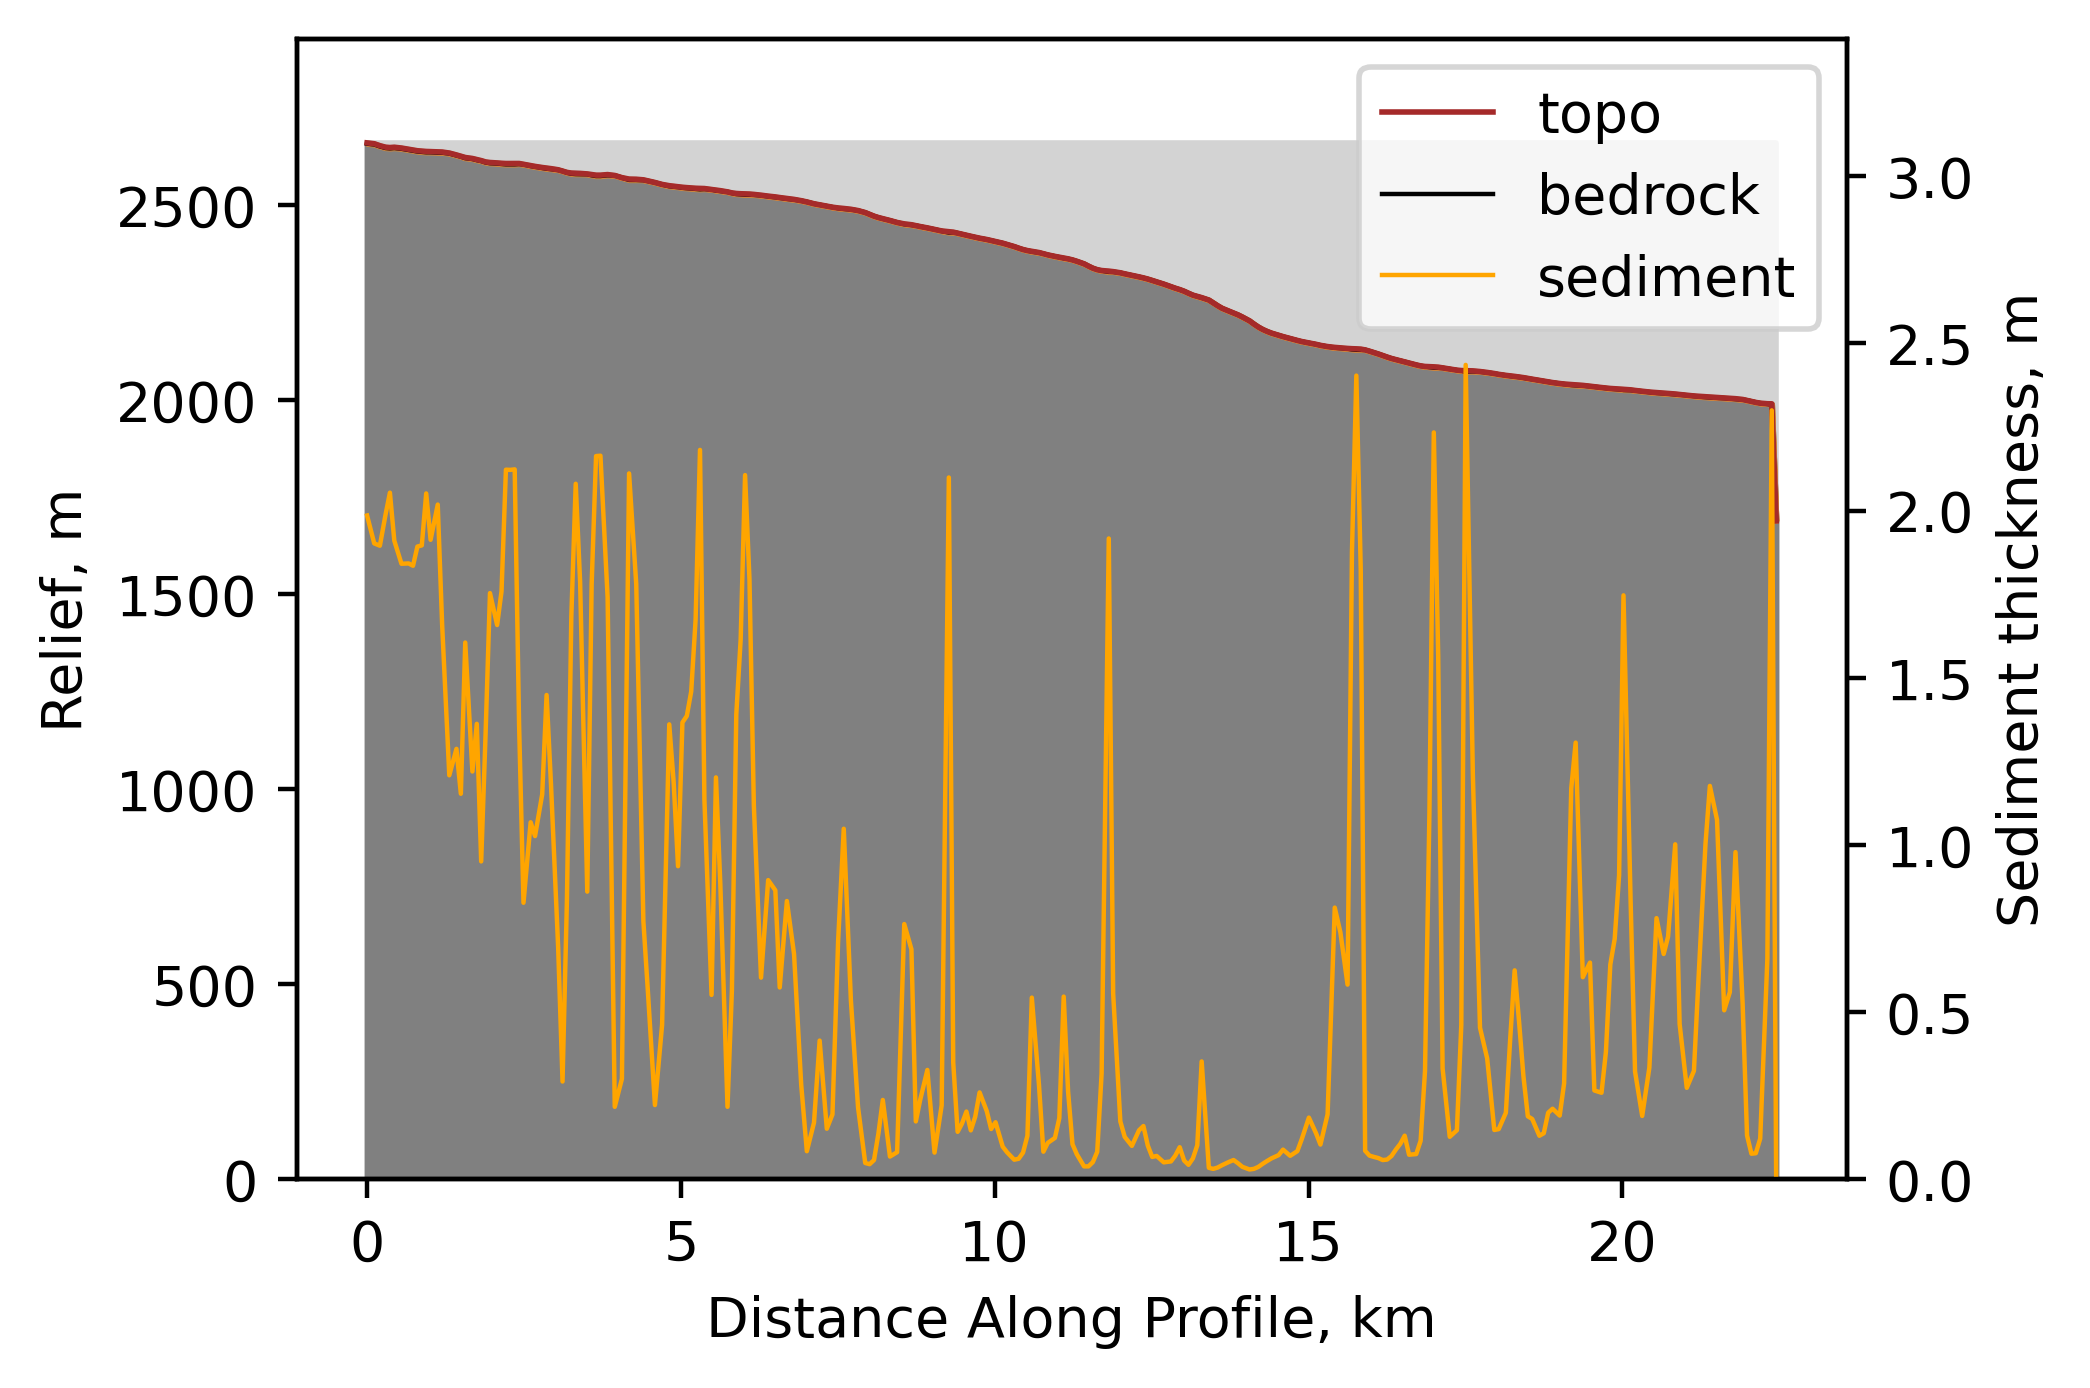

In [32]:
plot_profile_soil(mg3)